# Install Dependency

In [4]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3909, done.
remote: Counting objects: 100% (3909/3909), done.
remote: Compressing objects: 100% (3023/3023), done.
remote: Total 3909 (delta 1127), reused 1979 (delta 833), pack-reused 0
Receiving objects: 100% (3909/3909), 49.65 MiB | 34.68 MiB/s, done.
Resolving deltas: 100% (1127/1127), done.


In [5]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 20.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to b

In [1]:
# Upgrade numpy library
# Note for CC: After running this cell Restart Runtime for the next cell tu run properly
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# if there is error in this cell this part from 'from object_detection.builders import model_builder'
# run the above cell !pip install -U numpy and restart the runtime

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Fracture Classification Model

In [23]:
from tensorflow.keras.models import load_model
model = load_model('./fractured_classification_model.h5')

1/1 [==============================] - 0s 119ms/step
Predicted class: 0
Confidence: 0.26213548
THE UPLOADED X-RAY IMAGE IS: Fractured


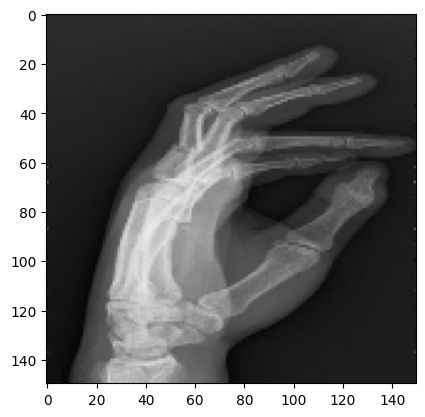

In [24]:
import PIL
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

img = load_img('/content/test/174_jpg.rf.b255d5b9833f54b9f1489915d4cec83e.jpg', target_size=(150, 150))
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

predictions = model.predict(x)

# Post-process the predictions
predicted_class = np.argmax(predictions[0])  # Assuming single-class prediction
confidence = predictions[0][predicted_class]

# Print the results
print("Predicted class:", predicted_class)
print("Confidence:", confidence)

a = predictions[0]

if a<0.5:
      op="Fractured"   
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED X-RAY IMAGE IS: "+str(op))

# Fracture Detection Model

In [29]:
import os
import zipfile

# Extract Object Detection Model

zip_ref = zipfile.ZipFile("/content/Fracture-Detection.zip", 'r')
zip_ref.extractall("/content/new_model")
zip_ref.close()

!mv /content/new_model/content/inference_graph .

In [34]:
# Inference Object detection
# The input is in /content/test Note: it can be multiple images
# the output will be place in /content/outputs
# 'a' is the result of Fracture Classification Model
# make sure there is 'outputs' folder where as the same level as below script is running

if a < 0.5:
  !python /content/detect_from_image.py \
    -m /content/inference_graph/saved_model \
    -l /content/bone-fractures_label_map.pbtxt \
    -i /content/test/

else:
  print('the image result is Normal')

2023-06-10 15:31:30.204941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
